# Download data and libs

Download data from Google drive and extract

Please change the code if you want to use different data

The extracted folder is saved at the path: /kaggle/working/

In [ ]:
!pip install gdown
!gdown --id 1_9NPC8E-kt4pU6rTi5lkh91eFR_jnFav --output sino_nom.zip
!unzip -u '/kaggle/working/sino_nom.zip'

## Install required libraries

In [ ]:
!pip install numpy-stl

# Processing 3D STL models

The g_path below is the path to 2 folders: stl file folder and sino_nom character image folder
If you want to run with new data, please check and make sure the path is correct

In [1]:
import numpy as np
from stl import mesh
import os
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import io
import cv2

# Image size
img_size = (256,256)


In [49]:
# Folder path: Change the data folder
g_path = 'wb_2D3Dretrieval_dataset/pairs'

# STL model folder
stl_path = os.path.join(g_path,'stl') 

# Process to 2D image from STL model folder
stl_2d_path = os.path.join(g_path,'stl_to_2d_pairs')

# Queries path
queries_path =  os.path.join(g_path,'print') 

# Number of file in the STL model folder
num_file= len(os.listdir(stl_path))

In [30]:
def crop(image):
    """
    This function will crop the Sino-Nom character inside the bounding box.
    The bounding box will be found by detecting contours.
    Input:
    :param image: the 2D Sino-Nom character image
    Output:
    :return: The image after cropping
    """
    contours, hierarchy = cv2.findContours(image ,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    cropped_image = None

    min_x = min_y = float('inf')
    max_x = max_y = 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if x==0 or y==0:
            continue
        # Tìm tọa độ min-max
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x + w)
        max_y = max(max_y, y + h)
    return cv2.resize(image[min_y:max_y, min_x:max_x], img_size)  

def stl_to_2d(file_path):
    """
    This function will process a 3D model into a 2D image.
    The STL model will be loaded from the given path, then it will be cut 6/7 of its thickness to get the top and saved to a Mesh array.
    After that, we will use the matplotlib library to plot the Mesh file from a specific angle and then save the figure to a buffer.
    Finally, the crop function will be used to crop the 2D image.
    Input:
    :param file_path: the path to the STL file
    Output:
    :return: 2D image generated from the 3D model
    """
    # Load the STL file
    _mesh = mesh.Mesh.from_file(file_path)
    # Compute the bounding box
    min_coords = np.min(_mesh.points, axis=0)
    max_coords = np.max(_mesh.points, axis=0)
    # Choose a cutting axis (e.g., the z-axis)
    cutting_axis = 2  # Assuming z-axis, change if needed
    # Find the coordinate value halfway between the minimum and maximum along the cutting axis
    cutting_plane = min_coords[cutting_axis] + 6*(max_coords[cutting_axis] - min_coords[cutting_axis]) / 7.0
    # Partition the model based on the cutting plane
    vectors_above_plane = []
    for vector in _mesh.vectors:
        # Check if all vertices of the triangle are above the cutting plane
        if np.all(vector[:, cutting_axis] > cutting_plane):
            vectors_above_plane.append(vector)
    # Create a new mesh object from the vectors above the cutting plane
    above_cutting_plane_mesh = mesh.Mesh(np.zeros(len(vectors_above_plane), dtype=mesh.Mesh.dtype))
    above_cutting_plane_mesh.vectors = vectors_above_plane

    figure = plt.figure()
    axes = figure.add_subplot(projection='3d')
    axes.view_init(elev=90, azim=-90)
    # Load the STL files and add the vectors to the plot
    poly_collection = mplot3d.art3d.Poly3DCollection(above_cutting_plane_mesh.vectors)
    poly_collection.set_color((0,0,0))  # play with color
    scale = above_cutting_plane_mesh.points.flatten()
    axes.auto_scale_xyz(scale, scale, scale)
    axes.add_collection3d(poly_collection)
    plt.grid(False)
    plt.axis('off')
    # Show the plot to the screen
    buffer = io.BytesIO()
    figure.savefig(buffer, format='jpg')
    buffer.seek(0)
    image_buffer = cv2.imdecode(np.frombuffer(buffer.getvalue(), dtype=np.uint8), -1)
    gray = cv2.cvtColor(image_buffer, cv2.COLOR_BGR2GRAY)
    ret,thresh_3d = cv2.threshold(gray,150,255,0)
    image_ = crop(thresh_3d)
    buffer.close()
    plt.close()
    return image_

Let's test the stl_to_2d funtion and plot the 2D image

(<matplotlib.image.AxesImage at 0x1ff3fbdc0d0>, (-0.5, 255.5, 255.5, -0.5))

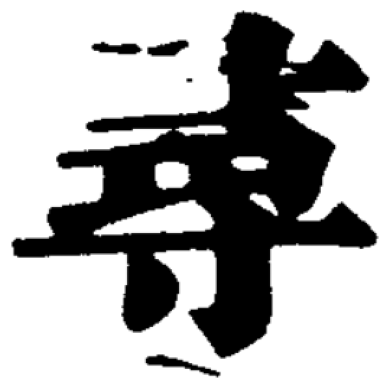

In [4]:
plt.imshow(stl_to_2d('wb_2D3Dretrieval_dataset/database/26.stl'), cmap = 'gray'), plt.axis('off')

## Then we will process all the 3D models and save the 2D images to a new folder.

In [5]:
# Process all the 3D models in folder pairs
stl_path = os.path.join(g_path,'stl') 
stl_2d_path = os.path.join(g_path,'stl_to_2d_pairs')
if not os.path.exists(stl_2d_path):
    os.mkdir(stl_2d_path) 
index=1
num_file= len(os.listdir(stl_path))
for file in os.listdir(stl_path): 
    print(f'{index}/{num_file}')
    index+=1
    path = os.path.join(stl_path,file)
    img_2d = stl_to_2d(path)
    out_path = os.path.join(stl_2d_path,file+'.png') 
    cv2.imwrite(out_path, img_2d)

1/228
2/228
3/228
4/228
5/228
6/228
7/228
8/228
9/228
10/228
11/228
12/228
13/228
14/228
15/228
16/228
17/228
18/228
19/228
20/228
21/228
22/228
23/228
24/228
25/228
26/228
27/228
28/228
29/228
30/228
31/228
32/228
33/228
34/228
35/228
36/228
37/228
38/228
39/228
40/228
41/228
42/228
43/228
44/228
45/228
46/228
47/228
48/228
49/228
50/228
51/228
52/228
53/228
54/228
55/228
56/228
57/228
58/228
59/228
60/228
61/228
62/228
63/228
64/228
65/228
66/228
67/228
68/228
69/228
70/228
71/228
72/228
73/228
74/228
75/228
76/228
77/228
78/228
79/228
80/228
81/228
82/228
83/228
84/228
85/228
86/228
87/228
88/228
89/228
90/228
91/228
92/228
93/228
94/228
95/228
96/228
97/228
98/228
99/228
100/228
101/228
102/228
103/228
104/228
105/228
106/228
107/228
108/228
109/228
110/228
111/228
112/228
113/228
114/228
115/228
116/228
117/228
118/228
119/228
120/228
121/228
122/228
123/228
124/228
125/228
126/228
127/228
128/228
129/228
130/228
131/228
132/228
133/228
134/228
135/228
136/228
137/228
138/228
139/

# Processing 2D images

In [4]:
def process_2d(img):
    """
    This funtion will change the 2D RGB image to a binary image
    :param img: the input image
    :return: binary image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh_2d = cv2.threshold(gray,150,255,0)
    return crop(thresh_2d)

# After processing the 3D models into 2D images, we find the top 5 models that are most similar for each 2D image.

## Template Matching

In [12]:
def find_similar(img_path):
    stl_2d_folder = stl_2d_path
    input_image = process_2d(cv2.imread(img_path))
    binary_images_folder = stl_2d_path
    image_matches = []

    for filename in os.listdir(binary_images_folder):
        image_path = os.path.join(binary_images_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # So khớp mẫu ảnh
        match = cv2.matchTemplate(image, input_image, cv2.TM_CCOEFF_NORMED)
        image_matches.append((filename, match.max()))

    sorted_images = sorted(image_matches, key=lambda x: x[1], reverse=True)
    top_5 = [path for path, match_value in sorted_images[:5]]
    return top_5

### Write to csv file

Finally, we write the results to a CSV file.
The file is saved at the global folder (g_path defined above)

In [10]:
# Create the label csv file
f = open(f"{g_path}/labels_pairs.csv", "w") 

queries_path =  os.path.join(g_path,'print') 

num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    f.write(filename + ',"' + filename.replace("png", "stl") + '"' +'\n')
f.close()

In [13]:
# Write the top 5 result to the CSV file
f = open(f"{g_path}/test_template.csv", "w")
f.write('query,label\n')
print(g_path)
queries_path =  os.path.join(g_path,'print') 
index = 1
num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    print(f'{index}/{num_queries}')
    index+=1
    img_path = os.path.join(queries_path,filename) 
    top5 = find_similar(img_path)
    top5_tostring = ','.join([n[:-4] for n in top5])
    f.write(filename + ',"' + top5_tostring +'"'+'\n')
f.close()

wb_2D3Dretrieval_dataset/pairs
1/228
2/228
3/228
4/228
5/228
6/228
7/228
8/228
9/228
10/228
11/228
12/228
13/228
14/228
15/228
16/228
17/228
18/228
19/228
20/228
21/228
22/228
23/228
24/228
25/228
26/228
27/228
28/228
29/228
30/228
31/228
32/228
33/228
34/228
35/228
36/228
37/228
38/228
39/228
40/228
41/228
42/228
43/228
44/228
45/228
46/228
47/228
48/228
49/228
50/228
51/228
52/228
53/228
54/228
55/228
56/228
57/228
58/228
59/228
60/228
61/228
62/228
63/228
64/228
65/228
66/228
67/228
68/228
69/228
70/228
71/228
72/228
73/228
74/228
75/228
76/228
77/228
78/228
79/228
80/228
81/228
82/228
83/228
84/228
85/228
86/228
87/228
88/228
89/228
90/228
91/228
92/228
93/228
94/228
95/228
96/228
97/228
98/228
99/228
100/228
101/228
102/228
103/228
104/228
105/228
106/228
107/228
108/228
109/228
110/228
111/228
112/228
113/228
114/228
115/228
116/228
117/228
118/228
119/228
120/228
121/228
122/228
123/228
124/228
125/228
126/228
127/228
128/228
129/228
130/228
131/228
132/228
133/228
134/228
135/2

### Visualize the results

In [16]:
# Visualize the results
def visualize_results(img_file_name):
    
    # Visualize the results
    queries_path =  os.path.join(g_path,'print') 
    img1_path = os.path.join(queries_path, img_file_name)

    img1_process = process_2d(cv2.imread(img1_path))
    
    # Print the file
    top_5 = find_similar(img1_path)
    for image_path in top_5:
        print(image_path)
        
    # Final results
    img2d_path = [os.path.join(stl_2d_path,p) for p in top_5]
    
    # Visualize
    img2d = [cv2.imread(os.path.join(stl_2d_path,p)) for p in top_5]
    plt.subplot(161),plt.imshow(process_2d(cv2.imread(img1_path)),cmap = 'gray'),plt.title('2D')
    plt.axis('off')
    plt.subplot(162),plt.imshow(img2d[0]),plt.title(top_5[0][:-8])
    plt.axis('off')
    plt.subplot(163),plt.imshow(img2d[1]),plt.title(top_5[1][:-8])
    plt.axis('off')
    plt.subplot(164),plt.imshow(img2d[2]),plt.title(top_5[2][:-8])
    plt.axis('off')
    plt.subplot(165), plt.imshow(img2d[3]),plt.title(top_5[3][:-8])
    plt.axis('off')
    plt.subplot(166),plt.imshow(img2d[4]),plt.title(top_5[4][:-8])
    plt.axis('off')
    plt.show()
        

98.stl.png
203.stl.png
144.stl.png
184.stl.png
136.stl.png


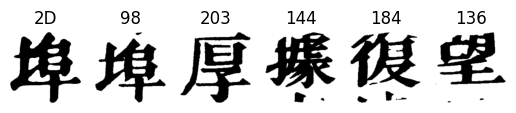

In [17]:
visualize_results("98.png")

## HOG

In [19]:
from skimage.feature import hog
from skimage import exposure
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Extract image feature
def feature_matching_HOG_similarity(image1, image2):
    # Feature 1
    features1, hog_image1 = hog(image1, orientations=9, pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2), visualize=True)

    # Feature 2
    features2, hog_image2 = hog(image2, orientations=9, pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2), visualize=True)

    # Reshape vectors
    features1 = features1.reshape(1, -1)
    features2 = features2.reshape(1, -1)

    # Similarity
    similarity = cosine_similarity(features1, features2)

    return similarity

def feature_hog(image):
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2), visualize=True)
    features = features.reshape(1, -1)
    
    return features

# Using cosine similarity to compare features
def feature_matching_HOG(features1, features2):
    similarity = cosine_similarity(features1, features2)

    return similarity


In [ ]:
stl_2d_hog = []
binary_images_stl_2d_folder = os.path.join(g_path,'stl_to_2d_pairs')
for filename in os.listdir(binary_images_stl_2d_folder):
        image_path = os.path.join(binary_images_stl_2d_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        features = feature_hog(image)
        stl_2d_hog.append((filename, features))

In [ ]:
def find_similar_HOG(img_path, stl_2d_hog):
    input_image = process_2d(cv2.imread(img_path))
    binary_images_folder = stl_2d_path
    image_matches = []
    
    input_image_feature = feature_hog(input_image)
    
    for filename, stl_2d_hog_feature in stl_2d_hog:
        # Cosin similarity
        match = feature_matching_HOG(stl_2d_hog_feature, input_image_feature)
        image_matches.append((filename, match.max()))

    sorted_images = sorted(image_matches, key=lambda x: x[1], reverse=True)
    top_5 = [path for path, match_value in sorted_images[:5]]
    return top_5

### Write to csv file

Finally, we write the results to a CSV file.
The file is saved at the global folder (g_path defined above)

In [21]:
# Create the label csv file
f = open(f"{g_path}/labels_pairs.csv", "w") 

queries_path =  os.path.join(g_path,'print') 

num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    f.write(filename + ',"' + filename.replace("png", "stl") + '"' +'\n')
f.close()

In [25]:
# Write the top 5 result to the CSV file
f = open(f"{g_path}/test_hog.csv", "w")
f.write('query,label\n')
print(g_path)
queries_path =  os.path.join(g_path,'print') 
index = 1
num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    print(f'{index}/{num_file}')
    index+=1
    img_path = os.path.join(queries_path,filename) 
    top5 = find_similar_HOG(img_path, stl_2d_hog)
    top5_tostring = ','.join([n[:-4] for n in top5])
    f.write(filename + ',"' + top5_tostring +'"'+'\n' )
f.close()

wb_2D3Dretrieval_dataset/pairs
1/228
2/228
3/228
4/228
5/228
6/228
7/228
8/228
9/228
10/228
11/228
12/228
13/228
14/228
15/228
16/228
17/228
18/228
19/228
20/228
21/228
22/228
23/228
24/228
25/228
26/228
27/228
28/228
29/228
30/228
31/228
32/228
33/228
34/228
35/228
36/228
37/228
38/228
39/228
40/228
41/228
42/228
43/228
44/228
45/228
46/228
47/228
48/228
49/228
50/228
51/228
52/228
53/228
54/228
55/228
56/228
57/228
58/228
59/228
60/228
61/228
62/228
63/228
64/228
65/228
66/228
67/228
68/228
69/228
70/228
71/228
72/228
73/228
74/228
75/228
76/228
77/228
78/228
79/228
80/228
81/228
82/228
83/228
84/228
85/228
86/228
87/228
88/228
89/228
90/228
91/228
92/228
93/228
94/228
95/228
96/228
97/228
98/228
99/228
100/228
101/228
102/228
103/228
104/228
105/228
106/228
107/228
108/228
109/228
110/228
111/228
112/228
113/228
114/228
115/228
116/228
117/228
118/228
119/228
120/228
121/228
122/228
123/228
124/228
125/228
126/228
127/228
128/228
129/228
130/228
131/228
132/228
133/228
134/228
135/2

### Visualize the results

In [28]:
# Visualize the results
def visualize_results(img_file_name):
    
    # Visualize the results
    queries_path =  os.path.join(g_path,'print') 
    img1_path = os.path.join(queries_path, img_file_name)

    img1_process = process_2d(cv2.imread(img1_path))
    
    # Print the directory
    top_5 = find_similar_HOG(img1_path, stl_2d_hog)
    for image_path in top_5:
        print(image_path)
        
    # Final results
    img2d_path = [os.path.join(stl_2d_path,p) for p in top_5]
    
    # Visualize
    img2d = [cv2.imread(os.path.join(stl_2d_path,p)) for p in top_5]
    plt.subplot(161),plt.imshow(process_2d(cv2.imread(img1_path)),cmap = 'gray'),plt.title('2D')
    plt.axis('off')
    plt.subplot(162),plt.imshow(img2d[0]),plt.title(top_5[0][:-8])
    plt.axis('off')
    plt.subplot(163),plt.imshow(img2d[1]),plt.title(top_5[1][:-8])
    plt.axis('off')
    plt.subplot(164),plt.imshow(img2d[2]),plt.title(top_5[2][:-8])
    plt.axis('off')
    plt.subplot(165), plt.imshow(img2d[3]),plt.title(top_5[3][:-8])
    plt.axis('off')
    plt.subplot(166),plt.imshow(img2d[4]),plt.title(top_5[4][:-8])
    plt.axis('off')
    plt.show()
        

18.stl.png
14.stl.png
62.stl.png
49.stl.png
21.stl.png


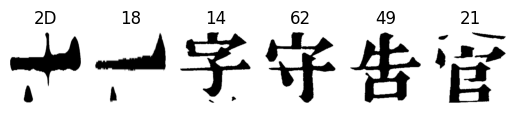

In [29]:
visualize_results("18.png")

## Structural Similarity

In [33]:
stl_2d_image = []
binary_images_stl_2d_folder = os.path.join(g_path,'stl_to_2d_pairs')
for filename in os.listdir(binary_images_stl_2d_folder):
        image_path = os.path.join(binary_images_stl_2d_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        stl_2d_image.append((filename, image))

In [34]:
from skimage.metrics import structural_similarity as compare_ssim

def find_similar_ssim(img_path, stl_2d_image):
    input_image = process_2d(cv2.imread(img_path))
    binary_images_folder = stl_2d_path
    image_matches = []

    for filename, image_query in stl_2d_image:
        # Struture SSIM
        match = compare_ssim(image_query, input_image)
        image_matches.append((filename, match.max()))

    sorted_images = sorted(image_matches, key=lambda x: x[1], reverse=True)
    top_5 = [path for path, match_value in sorted_images[:5]]
    return top_5

### Write to csv file

Finally, we write the results to a CSV file.
The file is saved at the global folder (g_path defined above)

In [ ]:
# Create the label csv file
f = open(f"{g_path}/labels_pairs.csv", "w") 

num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    f.write(filename + ',"' + filename.replace("png", "stl") + '"' +'\n')
f.close()

In [35]:
# Write the top 5 result to the CSV file
f = open(f"{g_path}/test_ssim.csv", "w")
f.write('query,label\n')
print(g_path)
queries_path =  os.path.join(g_path,'print') 
index = 1
num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    print(f'{index}/{num_file}')
    index+=1
    img_path = os.path.join(queries_path,filename) 
    top5 = find_similar_ssim(img_path, stl_2d_image)
    top5_tostring = ','.join([n[:-4] for n in top5])
    f.write(filename + ',"' + top5_tostring +'"'+'\n' )
f.close()

wb_2D3Dretrieval_dataset/pairs
1/228
2/228
3/228
4/228
5/228
6/228
7/228
8/228
9/228
10/228
11/228
12/228
13/228
14/228
15/228
16/228
17/228
18/228
19/228
20/228
21/228
22/228
23/228
24/228
25/228
26/228
27/228
28/228
29/228
30/228
31/228
32/228
33/228
34/228
35/228
36/228
37/228
38/228
39/228
40/228
41/228
42/228
43/228
44/228
45/228
46/228
47/228
48/228
49/228
50/228
51/228
52/228
53/228
54/228
55/228
56/228
57/228
58/228
59/228
60/228
61/228
62/228
63/228
64/228
65/228
66/228
67/228
68/228
69/228
70/228
71/228
72/228
73/228
74/228
75/228
76/228
77/228
78/228
79/228
80/228
81/228
82/228
83/228
84/228
85/228
86/228
87/228
88/228
89/228
90/228
91/228
92/228
93/228
94/228
95/228
96/228
97/228
98/228
99/228
100/228
101/228
102/228
103/228
104/228
105/228
106/228
107/228
108/228
109/228
110/228
111/228
112/228
113/228
114/228
115/228
116/228
117/228
118/228
119/228
120/228
121/228
122/228
123/228
124/228
125/228
126/228
127/228
128/228
129/228
130/228
131/228
132/228
133/228
134/228
135/2

### Visualize the results

In [36]:
# Visualize the results
def visualize_results(img_file_name):
    
    img1_path = os.path.join(queries_path, img_file_name)

    img1_process = process_2d(cv2.imread(img1_path))
    
    # Print the directory
    top_5 = find_similar_ssim(img1_path, stl_2d_image)
    for image_path in top_5:
        print(image_path)
        
    # Final results
    img2d_path = [os.path.join(stl_2d_path,p) for p in top_5]
    
    # Visualize
    img2d = [cv2.imread(os.path.join(stl_2d_path,p)) for p in top_5]
    plt.subplot(161),plt.imshow(process_2d(cv2.imread(img1_path)),cmap = 'gray'),plt.title('2D')
    plt.axis('off')
    plt.subplot(162),plt.imshow(img2d[0]),plt.title(top_5[0][:-8])
    plt.axis('off')
    plt.subplot(163),plt.imshow(img2d[1]),plt.title(top_5[1][:-8])
    plt.axis('off')
    plt.subplot(164),plt.imshow(img2d[2]),plt.title(top_5[2][:-8])
    plt.axis('off')
    plt.subplot(165), plt.imshow(img2d[3]),plt.title(top_5[3][:-8])
    plt.axis('off')
    plt.subplot(166),plt.imshow(img2d[4]),plt.title(top_5[4][:-8])
    plt.axis('off')
    plt.show()

221.stl.png
124.stl.png
208.stl.png
142.stl.png
63.stl.png


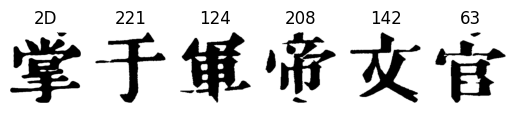

In [37]:
visualize_results("97.png")

## ORB

In [70]:
import types
import numpy as np
import cv2
from matplotlib import pyplot as plt

NoneType=type(None)

# ORB

def compute_orb(img1):
    orb = cv2.ORB_create()

    kp1, des1 = orb.detectAndCompute(img1,None)

    return kp1, des1

def orb_matcher(kp1, des1, kp2, des2):
    if type(des1)!=NoneType and type(des2)!=NoneType:
        # create BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        # Match descriptors.
        matches = bf.match(des1,des2)
        
        # Sort them in the order of their distance.
        matches = sorted(matches, key = lambda x:x.distance) 
        similarity = len(matches) / min(len(kp1), len(kp2))
        # return np.float64(len(matches))
        return np.float64(similarity)
    else: 
        print(des1, des2)
        return 0

In [72]:
# Special case
a, b = compute_orb(process_2d(cv2.imread("wb_2D3Dretrieval_dataset/pairs/print/5.png")))
a, b

((), None)

In [60]:
stl_2d_image_orb = []
binary_images_stl_2d_folder = os.path.join(g_path,'stl_to_2d_pairs')
for filename in os.listdir(binary_images_stl_2d_folder):
        image_path = os.path.join(binary_images_stl_2d_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        kp_image, des_image = compute_orb(image)
        stl_2d_image_orb.append((filename, kp_image, des_image))

In [71]:

def find_similar_ORB(img_path, stl_2d_image_orb):
    input_image = process_2d(cv2.imread(img_path))
    binary_images_folder = stl_2d_path
    image_matches = []
    
    kp_input_image, des_input_image = compute_orb(input_image)
    
    for filename, kp_database, des_database in stl_2d_image_orb:

        match = orb_matcher(kp_database, des_database, kp_input_image, des_input_image)
        image_matches.append((filename, match))

    sorted_images = sorted(image_matches, key=lambda x: x[1], reverse=True)
    top_5 = [path for path, match_value in sorted_images[:5]]
    return top_5

### Write to csv file

In [ ]:
# Create the label csv file
f = open(f"{g_path}/labels_pairs.csv", "w") 

num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    f.write(filename + ',"' + filename.replace("png", "stl") + '"' +'\n')
f.close()

In [72]:
# Write the top 5 result to the CSV file
f = open(f"{g_path}/test_orb.csv", "w")
f.write('query,label\n')
print(g_path)
queries_path =  os.path.join(g_path,'print') 
index = 1
num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    print(f'{index}/{num_file}')
    index+=1
    img_path = os.path.join(queries_path,filename) 
    top5 = find_similar_ORB(img_path, stl_2d_image_orb)
    top5_tostring = ','.join([n[:-4] for n in top5])
    f.write(filename + ',"' + top5_tostring +'"'+'\n' )
f.close()

wb_2D3Dretrieval_dataset/pairs
1/228
2/228
3/228
4/228
5/228
6/228
7/228
8/228
9/228
10/228
11/228
12/228
13/228
14/228
15/228
16/228
17/228
18/228
19/228
20/228
21/228
22/228
23/228
24/228
25/228
26/228
27/228
28/228
29/228
30/228
31/228
32/228
33/228
34/228
35/228
36/228
37/228
38/228
39/228
40/228
41/228
42/228
43/228
44/228
45/228
46/228
47/228
48/228
49/228
50/228
51/228
52/228
53/228
54/228
55/228
56/228
57/228
58/228
59/228
60/228
61/228
62/228
63/228
64/228
65/228
66/228
67/228
68/228
69/228
70/228
71/228
72/228
73/228
74/228
75/228
76/228
77/228
78/228
79/228
80/228
81/228
82/228
83/228
84/228
85/228
86/228
87/228
88/228
89/228
90/228
91/228
92/228
93/228
94/228
95/228
96/228
97/228
98/228
99/228
100/228
101/228
102/228
103/228
104/228
105/228
106/228
107/228
108/228
109/228
110/228
111/228
112/228
113/228
114/228
115/228
116/228
117/228
118/228
119/228
120/228
121/228
122/228
123/228
124/228
125/228
126/228
127/228
128/228
129/228
130/228
131/228
132/228
133/228
134/228
135/2

### Visualize the results

In [51]:
# Visualize the results
def visualize_results(img_file_name):
    
    img1_path = os.path.join(queries_path, img_file_name)

    img1_process = process_2d(cv2.imread(img1_path))
    
    # Print the directory
    top_5 = find_similar_ORB(img1_path, stl_2d_image_orb)
    for image_path in top_5:
        print(image_path)
        
    # Final results
    img2d_path = [os.path.join(stl_2d_path,p) for p in top_5]
    
    # Visualize
    img2d = [cv2.imread(os.path.join(stl_2d_path,p)) for p in top_5]
    plt.subplot(161),plt.imshow(process_2d(cv2.imread(img1_path)),cmap = 'gray'),plt.title('2D')
    plt.axis('off')
    plt.subplot(162),plt.imshow(img2d[0]),plt.title(top_5[0][:-8])
    plt.axis('off')
    plt.subplot(163),plt.imshow(img2d[1]),plt.title(top_5[1][:-8])
    plt.axis('off')
    plt.subplot(164),plt.imshow(img2d[2]),plt.title(top_5[2][:-8])
    plt.axis('off')
    plt.subplot(165), plt.imshow(img2d[3]),plt.title(top_5[3][:-8])
    plt.axis('off')
    plt.subplot(166),plt.imshow(img2d[4]),plt.title(top_5[4][:-8])
    plt.axis('off')
    plt.show()

37.stl.png
192.stl.png
62.stl.png
154.stl.png
128.stl.png


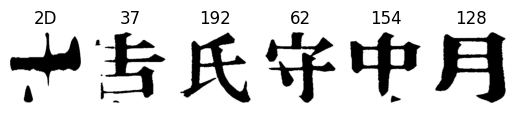

In [52]:
visualize_results("18.png")

## SIFT

In [56]:
import cv2 
import pysift 

# Calculate SIFT from cv2
def compute_sift_cv2(img1):
    sift = cv2.SIFT_create()

    # Keypoint and descriptor
    kp1, des1 = sift.detectAndCompute(img1, None)

    return kp1, des1

# Calculate SIFT from pysift
def compute_sift(image):
    return pysift.computeKeypointsAndDescriptors(image)

def sift_matcher(kp1, des1, kp2, des2):
    # Apply matcher
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches


def sift_matcher_2(kp1, des1, kp2, des2):
    # Apply matcher
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    topResults = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults.append([m])
    similarity = len(topResults) / min(len(kp1), len(kp2))
    return np.float64(similarity)

In [ ]:
# Calculate similarity 
def calculateMatches(kp1, des1, kp2, des2):
    bf = cv2.BFMatcher()
    
    matches = bf.knnMatch(des1,des2,k=2)
    topResults1 = []
    for m,n in matches:
        if m.distance < 0.4*n.distance:
            topResults1.append([m])
            
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = []
    for m,n in matches:
        if m.distance < 0.4*n.distance:
            topResults2.append([m])
    
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
                
    similarity = len(topResults) / min(len(kp1), len(kp2))
    return np.float64(similarity)

In [ ]:
# Another calculation
def calculateScore(matches,keypoint1,keypoint2):
    return len(matches)/min(len(keypoint1), len(keypoint2))


In [52]:
stl_2d_image_sift = []
in_dex = 1
binary_images_stl_2d_folder = os.path.join(g_path,'stl_to_2d-pairs')
for filename in os.listdir(binary_images_stl_2d_folder):
        print(in_dex)
        in_dex+=1
        image_path = os.path.join(binary_images_stl_2d_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        kp_image, des_image = compute_sift(image)
        stl_2d_image_sift.append((filename, kp_image, des_image))
        

In [57]:

def find_similar_SIFT(img_path, stl_2d_image_sift):
    input_image = process_2d(cv2.imread(img_path))
    binary_images_folder = stl_2d_path
    image_matches = []
    
    kp_input_image, des_input_image = compute_sift(input_image)
    
    for filename, kp_database, des_database in stl_2d_image_sift:
        # SIFT Matcher 1
        # match = sift_matcher(kp_database, des_database, kp_input_image, des_input_image)
        # # score = sum([m.distance for m in match])
        # score = calculateScore(match, kp_database, kp_input_image)
        # image_matches.append((filename, score))
        
        # # SIFT Matcher 2
        # match = sift_matcher_2(kp_database, des_database, kp_input_image, des_input_image)
        # score = match
        # image_matches.append((filename, score))
        
        # # Calculate Matches
        match = calculateMatches(kp_database, des_database, kp_input_image, des_input_image)
        score = match
        image_matches.append((filename, score))
        
    sorted_images = sorted(image_matches, key=lambda x: x[1], reverse=True)
    top_5 = [path for path, match_value in sorted_images[:5]]
    
    return top_5

### Write to the csv file

In [54]:
# Create the label csv file
f = open(f"{g_path}/labels_pairs.csv", "w") 

num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    f.write(filename + ',"' + filename.replace("png", "stl") + '"' +'\n')
f.close()

In [58]:
# Write the top 5 result to the CSV file
f = open(f"{g_path}/test_sift.csv", "w")
f.write('query,label\n')
print(g_path)
queries_path =  os.path.join(g_path,'print') 
index = 1
num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    print(f'{index}/{num_file}')
    index+=1
    img_path = os.path.join(queries_path,filename) 
    top5 = find_similar_SIFT(img_path, stl_2d_image_sift)
    top5_tostring = ','.join([n[:-4] for n in top5])
    f.write(filename + ',"' + top5_tostring +'"'+'\n' )
f.close()

wb_2D3Dretrieval_dataset/pairs
1/228
2/228
3/228
4/228
5/228
6/228
7/228
8/228
9/228
10/228
11/228
12/228
13/228
14/228
15/228
16/228
17/228
18/228
19/228
20/228
21/228
22/228
23/228
24/228
25/228
26/228
27/228
28/228
29/228
30/228
31/228
32/228
33/228
34/228
35/228
36/228
37/228
38/228
39/228
40/228
41/228
42/228
43/228
44/228
45/228
46/228
47/228
48/228
49/228
50/228
51/228
52/228
53/228
54/228
55/228
56/228
57/228
58/228
59/228
60/228
61/228
62/228
63/228
64/228
65/228
66/228
67/228
68/228
69/228
70/228
71/228
72/228
73/228
74/228
75/228
76/228
77/228
78/228
79/228
80/228
81/228
82/228
83/228
84/228
85/228
86/228
87/228
88/228
89/228
90/228
91/228
92/228
93/228
94/228
95/228
96/228
97/228
98/228
99/228
100/228
101/228
102/228
103/228
104/228
105/228
106/228
107/228
108/228
109/228
110/228
111/228
112/228
113/228
114/228
115/228
116/228
117/228
118/228
119/228
120/228
121/228
122/228
123/228
124/228
125/228
126/228
127/228
128/228
129/228
130/228
131/228
132/228
133/228
134/228
135/2

### Visualize the results

In [10]:
# Visualize the results
def visualize_results(img_file_name):
    
    img1_path = os.path.join(queries_path, img_file_name)

    img1_process = process_2d(cv2.imread(img1_path))
    
    # Print the directory
    top_5 = find_similar_SIFT(img1_path, stl_2d_image_sift)
    for image_path in top_5:
        print(image_path)
        
    # Final results
    img2d_path = [os.path.join(stl_2d_path,p) for p in top_5]
    
    # Visualize
    img2d = [cv2.imread(os.path.join(stl_2d_path,p)) for p in top_5]
    plt.subplot(161),plt.imshow(process_2d(cv2.imread(img1_path)),cmap = 'gray'),plt.title('2D')
    plt.axis('off')
    plt.subplot(162),plt.imshow(img2d[0]),plt.title(top_5[0][:-8])
    plt.axis('off')
    plt.subplot(163),plt.imshow(img2d[1]),plt.title(top_5[1][:-8])
    plt.axis('off')
    plt.subplot(164),plt.imshow(img2d[2]),plt.title(top_5[2][:-8])
    plt.axis('off')
    plt.subplot(165), plt.imshow(img2d[3]),plt.title(top_5[3][:-8])
    plt.axis('off')
    plt.subplot(166),plt.imshow(img2d[4]),plt.title(top_5[4][:-8])
    plt.axis('off')
    plt.show()

34.stl.png
187.stl.png
201.stl.png
151.stl.png
113.stl.png


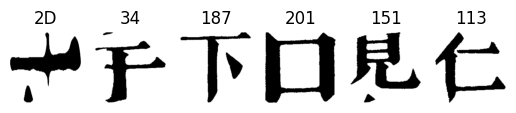

In [58]:
visualize_results("18.png")

## Histogram

In [59]:
# Calculate histogram and compare
def calculate_histogram(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    return hist

def calculate_similarity(hist1, hist2):
    similarity = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)
    
    return np.float64(similarity)

In [61]:

def find_similar_hist(img_path):
    stl_2d_folder = stl_2d_path
    input_image = process_2d(cv2.imread(img_path))
    binary_images_folder = stl_2d_path
    image_matches = []

    for filename in os.listdir(binary_images_folder):
        image_path = os.path.join(binary_images_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Struture SSIM
        match = calculate_similarity(calculate_histogram(image), calculate_histogram(input_image))
        image_matches.append((filename, match.max()))

    sorted_images = sorted(image_matches, key=lambda x: x[1], reverse=True)
    top_5 = [path for path, match_value in sorted_images[-5:]] 
    return top_5

### Write to the csv file

In [ ]:
# Create the label csv file
f = open(f"{g_path}/labels_pairs.csv", "w") 

num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    f.write(filename + ',"' + filename.replace("png", "stl") + '"' +'\n')
f.close()

In [62]:
# Write the top 5 result to the CSV file
f = open(f"{g_path}/test_hist.csv", "w")
f.write('query,label\n')
print(g_path)

index = 1
num_queries = len(os.listdir(queries_path))
for filename in os.listdir(queries_path):
    print(f'{index}/{num_file}')
    index+=1
    img_path = os.path.join(queries_path,filename) 
    top5 = find_similar_hist(img_path)
    top5_tostring = ','.join([n[:-4] for n in top5])
    f.write(filename + ',"' + top5_tostring +'"'+'\n' )
f.close()

wb_2D3Dretrieval_dataset/pairs
1/228
2/228
3/228
4/228
5/228
6/228
7/228
8/228
9/228
10/228
11/228
12/228
13/228
14/228
15/228
16/228
17/228
18/228
19/228
20/228
21/228
22/228
23/228
24/228
25/228
26/228
27/228
28/228
29/228
30/228
31/228
32/228
33/228
34/228
35/228
36/228
37/228
38/228
39/228
40/228
41/228
42/228
43/228
44/228
45/228
46/228
47/228
48/228
49/228
50/228
51/228
52/228
53/228
54/228
55/228
56/228
57/228
58/228
59/228
60/228
61/228
62/228
63/228
64/228
65/228
66/228
67/228
68/228
69/228
70/228
71/228
72/228
73/228
74/228
75/228
76/228
77/228
78/228
79/228
80/228
81/228
82/228
83/228
84/228
85/228
86/228
87/228
88/228
89/228
90/228
91/228
92/228
93/228
94/228
95/228
96/228
97/228
98/228
99/228
100/228
101/228
102/228
103/228
104/228
105/228
106/228
107/228
108/228
109/228
110/228
111/228
112/228
113/228
114/228
115/228
116/228
117/228
118/228
119/228
120/228
121/228
122/228
123/228
124/228
125/228
126/228
127/228
128/228
129/228
130/228
131/228
132/228
133/228
134/228
135/2

### Visualize the results

In [63]:
# Visualize the results
def visualize_results(img_file_name):
    
    img1_path = os.path.join(queries_path, img_file_name)
    
    # Print the directory
    top_5 = find_similar_hist(img1_path)
    for image_path in top_5:
        print(image_path)
    
    # Visualize
    img2d = [cv2.imread(os.path.join(stl_2d_path,p)) for p in top_5]
    plt.subplot(161),plt.imshow(process_2d(cv2.imread(img1_path)),cmap = 'gray'),plt.title('2D')
    plt.axis('off')
    plt.subplot(162),plt.imshow(img2d[0]),plt.title(top_5[0][:-8])
    plt.axis('off')
    plt.subplot(163),plt.imshow(img2d[1]),plt.title(top_5[1][:-8])
    plt.axis('off')
    plt.subplot(164),plt.imshow(img2d[2]),plt.title(top_5[2][:-8])
    plt.axis('off')
    plt.subplot(165), plt.imshow(img2d[3]),plt.title(top_5[3][:-8])
    plt.axis('off')
    plt.subplot(166),plt.imshow(img2d[4]),plt.title(top_5[4][:-8])
    plt.axis('off')
    plt.show()

142.stl.png
101.stl.png
10.stl.png
214.stl.png
211.stl.png


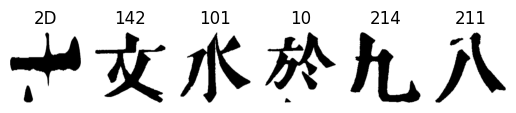

In [64]:
visualize_results("18.png")